In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Exploration

## Dataset Summary

The dataset contains information on various features related to a specific context. Below is a brief description of each variable:

1. **id**: An identifier for each record
2. **clonesize**: The size of clones (m2)
3. **honeybee**: Honey bee density (m2/min)
4. **bumbles**: Bumble bee density (m2/min)
5. **andrena**: Andrena bees density (m2/min)
6. **osmia**: Osmia bee density (m2/min)
7. **MaxOfUpperTRange**: Maximum value of Upper Temperature Range
8. **MinOfUpperTRange**: Minimum value of Upper Temperature Range
9. **AverageOfUpperTRange**: Average value of Upper Temperature Range
10. **MaxOfLowerTRange**: Maximum value of Lower Temperature Range
11. **MinOfLowerTRange**: Minimum value of Lower Temperature Range
12. **AverageOfLowerTRange**: Average value of Lower Temperature Range
13. **RainingDays**: Number of days with rain
14. **AverageRainingDays**: Average number of raining days
15. **fruitset**: Fruit set information
16. **fruitmass**: Mass of the fruit
17. **seeds**: Number of seeds

Each record contains the yield amount for an entire blooming season as seen in the aggregated measures

In [13]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print("train_df shape: ", train_df.shape)
print("test_df shape: ", test_df.shape)
test_df.info()

train_df shape:  (15289, 18)
test_df shape:  (10194, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10194 entries, 0 to 10193
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10194 non-null  int64  
 1   clonesize             10194 non-null  float64
 2   honeybee              10194 non-null  float64
 3   bumbles               10194 non-null  float64
 4   andrena               10194 non-null  float64
 5   osmia                 10194 non-null  float64
 6   MaxOfUpperTRange      10194 non-null  float64
 7   MinOfUpperTRange      10194 non-null  float64
 8   AverageOfUpperTRange  10194 non-null  float64
 9   MaxOfLowerTRange      10194 non-null  float64
 10  MinOfLowerTRange      10194 non-null  float64
 11  AverageOfLowerTRange  10194 non-null  float64
 12  RainingDays           10194 non-null  float64
 13  AverageRainingDays    10194 non-null  float64
 14  fruitset     

In [14]:
test_df.head(5)

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569
1,15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956
2,15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644
3,15292,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091
4,15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019


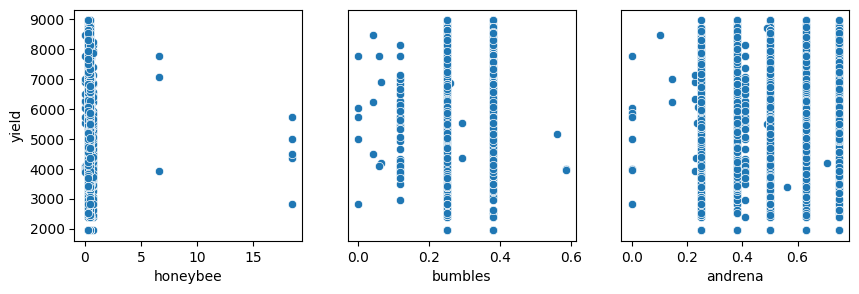

In [25]:
bee_df = train_df[["honeybee", "bumbles", "andrena", "osmia", "yield", "clonesize"]]

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for i in range(3):
    sns.scatterplot(x = bee_df.iloc[:, i], y= bee_df["yield"], ax=axes[i])
    if i > 0:
        axes[i].set_ylabel('')
        axes[i].set_yticks([])

<AxesSubplot: >

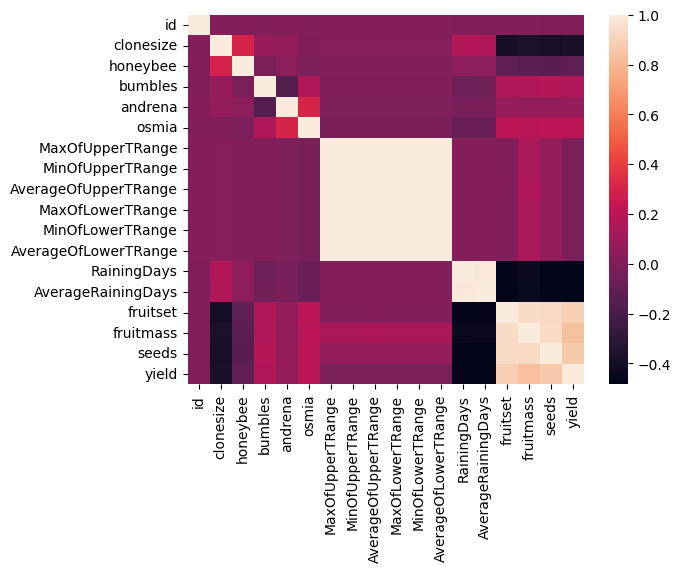

In [26]:
sns.heatmap(train_df.corr())

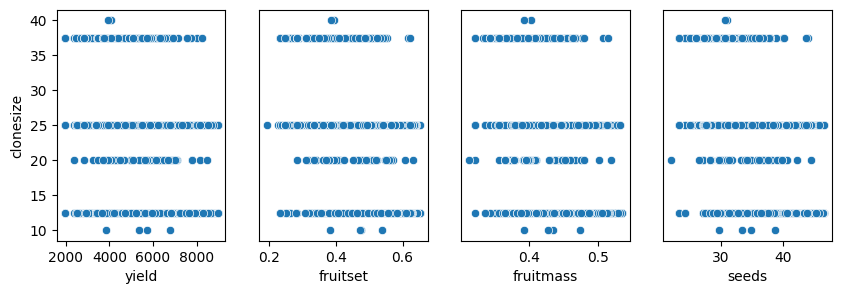

In [32]:
# the size of a blueberry clone is negatively correlated with yield, fruitset, fruitmass, and seeds?
unintuitive_df = train_df[["yield", "fruitset", "fruitmass", "seeds", "clonesize"]]

fig, ax = plt.subplots(1, 4, figsize=(10, 3))
for i in range(4):
    sns.scatterplot(x = unintuitive_df.iloc[:, i], y = train_df["clonesize"], ax=ax[i])
    if i > 0:
        ax[i].set_ylabel('')
        ax[i].set_yticks([])

In [47]:
# find duplications
duplicates_df = train_df.loc[train_df["yield"].duplicated()]

# hypothesis: synthetic data created different categorical pairings which could show up later
duplicates_df.sort_values(by="yield", inplace=True)
duplicates_df["yield"].value_counts()

C:\Users\commo\AppData\Local\Temp\ipykernel_22976\2391039509.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates_df.sort_values(by="yield", inplace=True)


6251.61184    32
7667.83619    31
6687.25926    31
6528.79888    31
8538.46200    31
              ..
6034.64214     9
8605.19995     9
7270.31832     9
4952.98560     8
5902.33288     6
Name: yield, Length: 776, dtype: int64

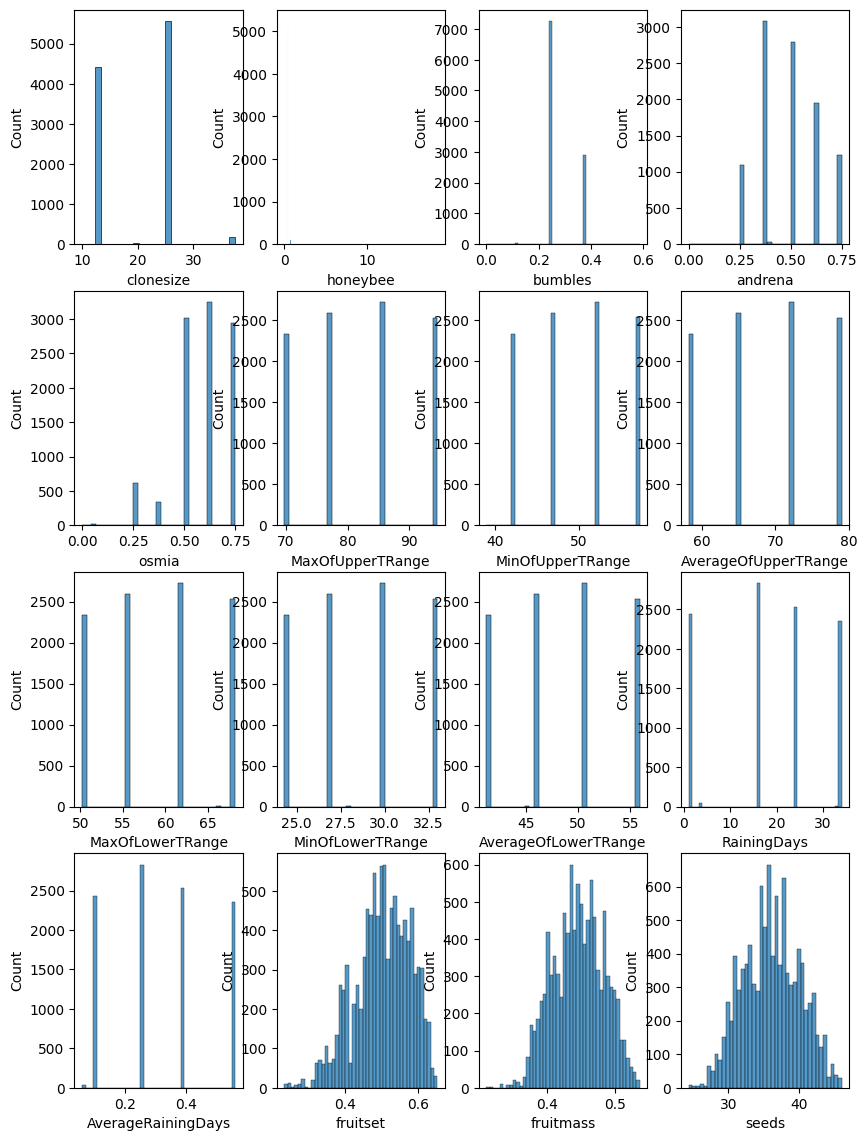

In [7]:
fig, ax = plt.subplots(4,4, figsize =(10,14))

for i, column in enumerate(test_df.columns[1:]):
    sns.histplot(test_df[column], ax=ax[i//4, i%4])

In [8]:
train = pd.read_csv('train.csv')
train.head(5)

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


# Submission

In [9]:
fold = KFold(n_splits=5, shuffle=True, random_state=42)
regressor = ElasticNetCV(cv=fold, random_state=0)

# create folds 
X = train.iloc[:,1:-1]
y = train['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

RMSE:  746.3015504568742


(0.0, 10000.0)

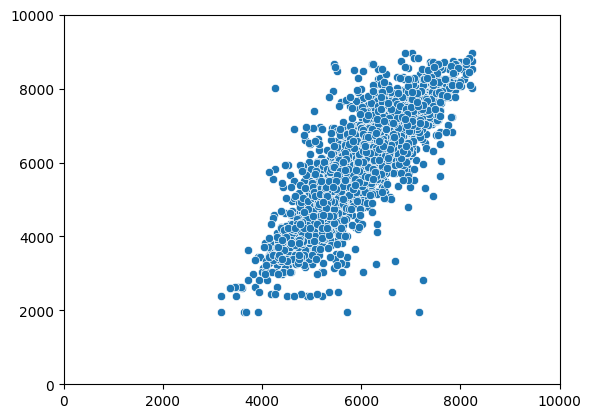

In [10]:
sns.scatterplot(y=y_test.values, x=y_pred)

# set scale 
plt.xlim(0, 10000)
plt.ylim(0, 10000)

<AxesSubplot: xlabel='yield', ylabel='Count'>

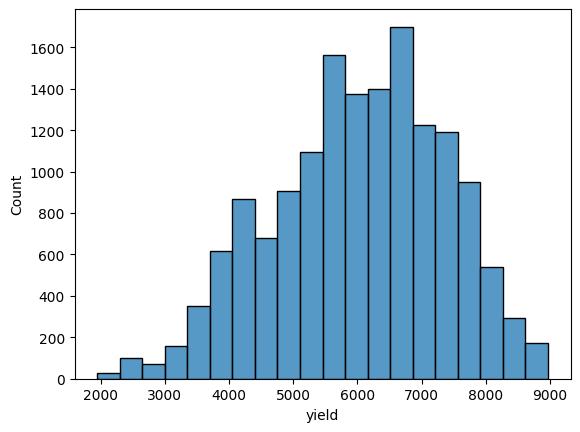

In [11]:
# histogram of yield 
sns.histplot(y, bins=20)

In [12]:
results = regressor.predict(test_df.iloc[:,1:])

submission = pd.DataFrame({'id': test_df['id'], 'yield': results})
submission.to_csv('submission.csv', index=False)